In [13]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
from utl.Validating import UnetValidatingApp
import SimpleITK as sitk
import numpy as np
import astra
import torch
import torchvision.transforms as transforms
import scipy as sp
import scipy.ndimage
import torch
from util.imageprocessing import rescale
import numpy as np
from skimage.filters import unsharp_mask
import nibabel as nib
import numpy as np
from skimage.transform import resize


In [14]:

def display_images_with_alpha_numpy(image_z, alpha, fixed, moving, vmin=[], vmax=[]):
    img = (1.0 - alpha)*fixed[image_z,:,:] + alpha*moving[image_z,:,:] 
    plt.figure(figsize=(16,9))
    plt.imshow(img,cmap=plt.cm.Greys_r, vmin=vmin,vmax=vmax);
    plt.axis('off')
    plt.show()

def display_images_with_alpha_numpy1(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[image_z,:,:] + alpha*moving[image_z,:,:] 
    plt.figure(figsize=(16,9))
    plt.imshow(img,cmap=plt.cm.Greys_r, vmin=-0.06,vmax=0.22);
    plt.axis('off')
    plt.show()
def display_images_with_alpha_numpy2(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[image_z,:,:] + alpha*moving[image_z,:,:] 
    plt.figure(figsize=(16,9))
    plt.imshow(img,cmap=plt.cm.Greys_r, vmin=-1,vmax=1);
    plt.axis('off')
    plt.show()

In [15]:
def elastixreg(f,m,img=None):
    fixed_image =  sitk.GetImageFromArray(f)
    moving_image = sitk.GetImageFromArray(m)
    

    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_image)
    elastixImageFilter.SetMovingImage(moving_image)
    elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
    elastixImageFilter.SetParameter('DefaultPixelValue', str(0))
    elastixImageFilter.SetParameter('FinalBSplineInterpolationOrder ', '3')
    elastixImageFilter.SetParameter('FixedImagePyramid ', 'FixedRecursiveImagePyramid')
    elastixImageFilter.SetParameter('MovingImagePyramid ', 'MovingRecursiveImagePyramid')
    elastixImageFilter.SetParameter('AutomaticTransformInitialization', 'true')
    elastixImageFilter.SetParameter('Interpolator', 'BSplineInterpolator')
    elastixImageFilter.SetParameter('NumberOfResolutions', '6')


    elastixImageFilter.Execute()

    if img is None: 
        RR=elastixImageFilter.GetResultImage()
        RR=sitk.GetArrayFromImage(RR)

    else:
        thirdImage=sitk.GetImageFromArray(img)
        transformParameterMap = elastixImageFilter.GetTransformParameterMap()

        transformix = sitk.TransformixImageFilter()
        transformix.SetTransformParameterMap(transformParameterMap)
        transformix.SetMovingImage(thirdImage)

        transformix.Execute()
        RR=transformix.GetResultImage()
        RR=sitk.GetArrayFromImage(RR)
    return RR

In [16]:
def sitkreg(f,m):
    fixed_image =  sitk.GetImageFromArray(f)
    moving_image = sitk.GetImageFromArray(m)

    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                        moving_image, 
                                                        sitk.Euler2DTransform(), 
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set the initial moving and optimized transforms.
    optimized_transform = sitk.Euler2DTransform()    
    registration_method.SetMovingInitialTransform(initial_transform)
    registration_method.SetInitialTransform(optimized_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    # registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
    # registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
    # registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
    # registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

    # Need to compose the transformations after registration.
    final_transform_v4 = registration_method.Execute(fixed_image, moving_image)
    #final_transform_v4.AddTransform(initial_transform)
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    # resample.SetDefaultPixelValue=0.5

    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(final_transform_v4)
    # moving_image = sitk.GetImageFromArray(V1)
    RegisteredE=resample.Execute(moving_image)
    RegisteredE=sitk.GetArrayFromImage(RegisteredE)
    return RegisteredE

    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [17]:
ValApp=UnetValidatingApp(val_dir='TestData')

ValApp.getCase(1)

Testing on cuda.
initialize network with normal
initialize network with normal
the file name are 


 Small FOV 

('TestData\\SFOV\\P00_CT1_SFOV_S000_0.nii', 'TestData\\SFOV\\P00_CT1_SFOV_S000_1.nii', 'TestData\\SFOV\\P00_CT1_SFOV_S000_2.nii')

 CTD 

('TestData\\CTD\\P00_CTD_0.nii', 'TestData\\CTD\\P00_CTD_1.nii', 'TestData\\CTD\\P00_CTD_2.nii')

 Large FOV 

('TestData\\LFOV\\P00_CT1_LFOV_S000_0.nii', 'TestData\\LFOV\\P00_CT1_LFOV_S000_1.nii', 'TestData\\LFOV\\P00_CT1_LFOV_S000_2.nii')


In [18]:
Orig=np.concatenate((ValApp.projo,ValApp.projo),axis=0)
Orig.shape

(6, 512, 512)

In [19]:
interact(display_images_with_alpha_numpy, image_z=(0,ValApp.proji.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(ValApp.proji), moving=fixed(Orig));

interactive(children=(IntSlider(value=2, description='image_z', max=5), FloatSlider(value=0.5, description='al…

In [20]:
a='ResultCNN_3/test_G.pth'
# b is the best , e,f next best
NNFileName=a
ValApp.doValidation(NNFileName)
ValApp.out.shape

(3, 512, 512)

In [21]:
sitk.Show(sitk.GetImageFromArray(ValApp.out))

TESTING !!!!!!!!!!!!!!

In [22]:

Testadd=[]
for jadd in range(len(ValApp.Case.CTDaddress)):
    cadd=ValApp.Case.CTDaddress[jadd]
    Testadd.append((cadd).replace('CTD','CTDh'))

CTDplan=np.stack((nib.load(Testadd[0]).get_fdata().astype(np.float32),nib.load(Testadd[1]).get_fdata().astype(np.float32),nib.load(Testadd[2]).get_fdata().astype(np.float32)),axis=0)
# CTDplan=CTDplan[np.newaxis,:]
Out=ValApp.out

Estimated Gaussian noise standard deviation = 0.000735398219751131


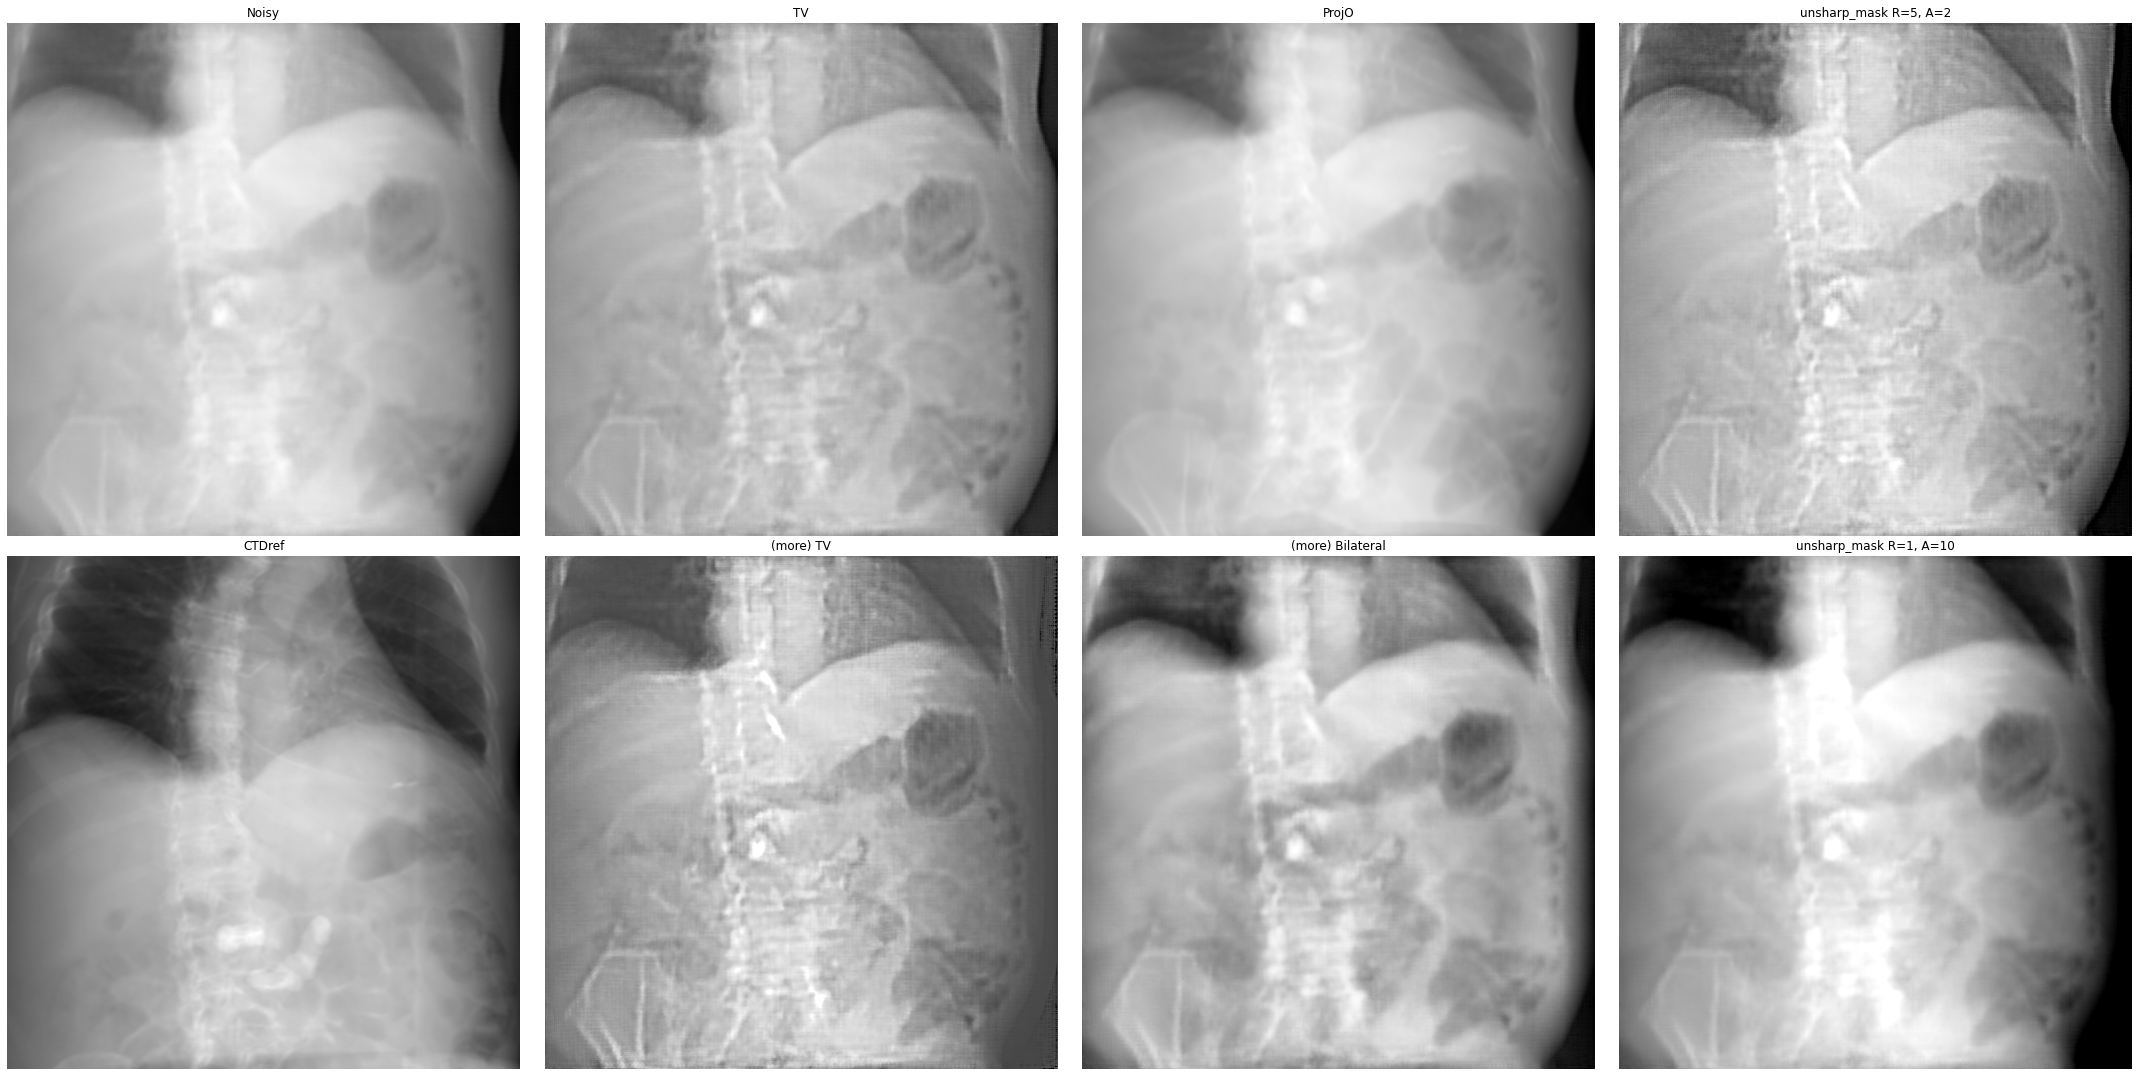

In [23]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

from skimage.exposure import match_histograms
from skimage import exposure

Slc=0

# CTDref=CTDplan[Slc,:,:][np.newaxis,:]
CTDref=CTDplan[Slc,:,:]
# CTDref = CTDref.squeeze(0) - CTDref.squeeze(0).min()
# CTDref=CTDref/CTDref.max()
# noisy=ValApp.out[Slc,:,:][np.newaxis,:]
noisy=ValApp.out[Slc,:,:]
noisy=noisy-noisy.min()
# noisy =noisy.squeeze(0) - noisy.squeeze(0).min()
# noisy=noisy/noisy.max()

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=False, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')

a_blur=denoise_tv_chambolle(noisy, weight=1, multichannel=False)
a=noisy+(noisy-a_blur)*2

ax[0, 1].imshow(a)
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
# b=denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=2,
#                 multichannel=False)
ax[0, 2].imshow(ValApp.projo[Slc,:,:])
ax[0, 2].axis('off')
ax[0, 2].set_title('ProjO')
c=unsharp_mask(noisy, radius=4, amount=3)


ax[0, 3].imshow(c)
ax[0, 3].axis('off')
ax[0, 3].set_title('unsharp_mask R=5, A=2')
# d=unsharp_mask(CTDref, radius=3, amount=2)
matched = match_histograms(noisy, CTDref)
d=unsharp_mask(matched, radius=4, amount=3)
ax[1, 1].imshow(d)
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
# e=denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=2,
#                 multichannel=False)
e = exposure.equalize_adapthist(noisy)
ax[1, 2].imshow(e)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
p5, p98 = np.percentile(noisy, (5, 98))
f = exposure.rescale_intensity(noisy, in_range=(p5, p98))
# f=unsharp_mask(noisy, radius=6, amount=10)
ax[1, 3].imshow(f)
ax[1, 3].axis('off')
ax[1, 3].set_title('unsharp_mask R=1, A=10')
ax[1, 0].imshow(CTDref)
ax[1, 0].axis('off')
ax[1, 0].set_title('CTDref')

fig.tight_layout()

plt.show()

# Images=np.stack((original,noisy,a,b,c,d,e,f),axis=0)

# p2

In [24]:
interact(display_images_with_alpha_numpy, image_z=(0,ValApp.out.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(Out), moving=fixed(ValApp.projo), vmin=0, vmax=+1);

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [25]:
interact(display_images_with_alpha_numpy, image_z=(0,ValApp.out.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(Out), moving=fixed(CTDplan));

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [47]:
from utl.pytorch_morph import *

Out_registered=np.zeros_like(CTDplan)
Out_registered_tophat=np.zeros_like(CTDplan)
Out_registered_tophatrec=np.zeros_like(CTDplan)
CTDplan_tophat=np.zeros_like(CTDplan)
CTDplan_tophatrec=np.zeros_like(CTDplan)
for Slc in range(3):



    CTDref=CTDplan[Slc,:,:][np.newaxis,:].squeeze(0)
    if Slc ==0:
        CTDref0=CTDref
    # CTDref = CTDref.squeeze(0) - CTDref.squeeze(0).min()
    # CTDref=CTDref/CTDref.max()
    noisy=ValApp.out[Slc,:,:][np.newaxis,:].squeeze(0)
    # noisy =noisy.squeeze(0) - noisy.squeeze(0).min()
    # noisy=noisy/noisy.max()

    Oorig=ValApp.projo[Slc,:,:][np.newaxis,:].squeeze(0)

    # matched = match_histograms(noisy, CTDref)
    # d=unsharp_mask(matched, radius=4, amount=3)

    # a_blur=denoise_tv_chambolle(noisy, weight=1, multichannel=False)
    # c=noisy+(noisy-a_blur)*2
    
    
    # c=unsharp_mask(noisy, radius=4, amount=3)   
    # CTDref=unsharp_mask(CTDref, radius=3, amount=2)

    e = exposure.equalize_adapthist(noisy)
    CTDrefforreg = exposure.equalize_adapthist(CTDref)
    if Slc ==0:
        CTDrefforreg0=CTDrefforreg
    
    
    # p5, p98 = np.percentile(noisy, (5, 98))
    # f = exposure.rescale_intensity(noisy, in_range=(p5, p98))
    
    
    
    
    CTSforreg=e

    if Slc ==0:
        CTSforreg0=CTSforreg
    
    RS=round(512*7/15)
    HRS=round(RS/2)
    x, y =np.meshgrid(np.linspace(-HRS,HRS,num=2*HRS),np.linspace(-HRS,HRS,num=2*HRS))
    dst = np.sqrt(x*x+y*y)
    
    # Initializing sigma and muu
    sigma = HRS/2-round(HRS*5/100)
    muu = 0.000
    
    # Calculating Gaussian array
    gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
    Temp=resize(ValApp.proji[Slc,:,:],(2*HRS,2*HRS))
    # Out_Imprinted=c
    Out_Imprinted=noisy
    Out_Imprinted[256-HRS:256+HRS,256-HRS:256+HRS]=Temp * (gauss) + Out_Imprinted[256-HRS:256+HRS,256-HRS:256+HRS] * (1- gauss)
    V1=Out_Imprinted[np.newaxis,:]

    # # V1 =V1.squeeze(0) - V1.squeeze(0).min()
    # # V1=V1/V1.max()
    # # V1=V1[np.newaxis,:]
    # V2=ValApp.out[Slc,:,:][np.newaxis,:]


    RR = elastixreg(CTDrefforreg,CTSforreg,V1.squeeze(0))
    # RR = sitkreg(CTDref,V1.squeeze(0))

    # sitk.Show(sitk.GetImageFromArray(Images1))
    RR=RR[np.newaxis,:]

    # # Structural element Sphere 3x3
    # strel = np.ones((30, 30))
    # origin = tuple(((np.array((strel.shape))-1)/2).astype(int))

    # # Pytorch tophat
    # image_tensor = torch.tensor(RR, dtype=torch.float)
    # strel_tensor = torch.tensor(strel, dtype=torch.bool)
    # tophat_image_pytorch = tophat_pytorch(image_tensor, strel_tensor, origin=origin)
    # tophat_image_pytorch=tophat_image_pytorch.numpy()
    # tophatrec_image_pytorch = tophat_recon_pytorch(image_tensor, strel_tensor, origin=origin,k=5)
    # tophatrec_image_pytorch=tophatrec_image_pytorch.numpy()

    # # Pytorch tophatrec
    # image_tensor = torch.tensor(CTDref[np.newaxis,:], dtype=torch.float)
    # strel_tensor = torch.tensor(strel, dtype=torch.bool)
    # tophat_image_pytorch_ref = tophat_pytorch(image_tensor, strel_tensor, origin=origin)
    # tophat_image_pytorch_ref=tophat_image_pytorch_ref.numpy()
    # tophatrec_image_pytorch_ref = tophat_recon_pytorch(image_tensor, strel_tensor, origin=origin,k=5)
    # tophatrec_image_pytorch_ref=tophatrec_image_pytorch_ref.numpy()

    # # V2=np.concatenate((CTDref[np.newaxis,:],RR,tophat_image_pytorch,tophat_image_pytorch_ref),axis=0)
    V2=np.concatenate((CTDref[np.newaxis,:],RR),axis=0)
    # V2Tophat=np.concatenate((tophat_image_pytorch,tophat_image_pytorch_ref),axis=0)
    

    # # CTDplan_tophatrec[np.where(CTDplan_tophatrec<0)]=0
    # # Out_registered_tophatrec[np.where(Out_registered_tophatrec<0)]=0

    # CTDplan_tophatrec[Slc,:,:] = tophatrec_image_pytorch_ref
    Out_registered[Slc,:,:]=V2[1,:,:]
    # Out_registered_tophat[Slc,:,:]=V2Tophat[0,:,:]
    
    # Out_registered_tophatrec[Slc,:,:]=tophatrec_image_pytorch
    
    # CTDplan_tophat[Slc,:,:]=V2Tophat[1,:,:]


    # print(Slc)
    # # sitk.Show(sitk.GetImageFromArray(V2))
    # # sitk.Show(sitk.GetImageFromArray(V2Tophat))




In [48]:
interact(display_images_with_alpha_numpy, image_z=(0,CTDrefforreg0[np.newaxis,:].shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(CTDrefforreg0[np.newaxis,:]), moving=fixed(CTSforreg0[np.newaxis,:]),vmin=-0,vmax=1);

interactive(children=(IntSlider(value=0, description='image_z', max=0), FloatSlider(value=0.5, description='al…

In [44]:
CTDrefforreg.shape

(512, 512)

In [28]:
interact(display_images_with_alpha_numpy, image_z=(0,CTDplan_tophat.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(ValApp.out), moving=fixed(Out_registered),vmin=-0,vmax=1);

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [29]:
# image_tensor = torch.tensor(CTDplan[0,:,:][np.newaxis,:], dtype=torch.float)
# strel_tensor = torch.tensor(strel, dtype=torch.bool)
# CTDplan_tophatrec2 = tophat_recon_pytorch(image_tensor, strel_tensor, origin=origin,k=2)
# CTDplan_tophatrec5 = tophat_recon_pytorch(image_tensor, strel_tensor, origin=origin,k=5)
interact(display_images_with_alpha_numpy, image_z=(0,Out_registered_tophat.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(CTDplan_tophatrec), moving=fixed(Out_registered_tophatrec),vmin=-0.5,vmax=0.5);

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [30]:
# sitk.Show(sitk.GetImageFromArray(Out_registered_tophatrec))
# sitk.Show(sitk.GetImageFromArray(CTDplan_tophatrec))

In [31]:
interact(display_images_with_alpha_numpy, image_z=(0,CTDplan_tophat.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(CTDplan_tophat), moving=fixed(Out_registered_tophat),vmin=-0.5,vmax=0.5);

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [32]:
interact(display_images_with_alpha_numpy, image_z=(0,Out_registered.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(CTDplan), moving=fixed(Out_registered));

interactive(children=(IntSlider(value=1, description='image_z', max=2), FloatSlider(value=0.5, description='al…

In [33]:
Savedir='test/'
for Slc in range(3):
    print(Slc)
    # CTD
    nimg = nib.Nifti1Image(CTDplan[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTD' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)

    nimg = nib.Nifti1Image(CTDplan_tophat[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTDTH' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)

    nimg = nib.Nifti1Image(CTDplan_tophatrec[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTDTHrec' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)    


    # CTO
    nimg = nib.Nifti1Image(ValApp.projo[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTO' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)

    # nimg = nib.Nifti1Image(ValApp.projo[Slc,:,:], np.eye(4))
    # filename='test'+ '_' + 'CTO' + '_' + str(Slc) 
    # nib.save(nimg, Savedir + filename)


    # CTS
    nimg = nib.Nifti1Image(Out_registered[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTS' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)

    nimg = nib.Nifti1Image(Out_registered_tophat[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTSTH' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)

    nimg = nib.Nifti1Image(Out_registered_tophatrec[Slc,:,:], np.eye(4))
    filename='test'+ '_' + 'CTSTHrec' + '_' + str(Slc) 
    nib.save(nimg, Savedir + filename)
    



0
1
2


In [34]:
# fixed_image =  sitk.GetImageFromArray(CTDref)
# moving_image = sitk.GetImageFromArray(V1.squeeze(0))

# initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
#                                                       moving_image, 
#                                                       sitk.Euler2DTransform(), 
#                                                       sitk.CenteredTransformInitializerFilter.GEOMETRY)

# registration_method = sitk.ImageRegistrationMethod()

# # Similarity metric settings.
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
# registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
# registration_method.SetMetricSamplingPercentage(0.01)

# registration_method.SetInterpolator(sitk.sitkLinear)

# # Optimizer settings.
# registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
# registration_method.SetOptimizerScalesFromPhysicalShift()

# # Setup for the multi-resolution framework.            
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# # Set the initial moving and optimized transforms.
# optimized_transform = sitk.Euler2DTransform()    
# registration_method.SetMovingInitialTransform(initial_transform)
# registration_method.SetInitialTransform(optimized_transform, inPlace=False)

# # Connect all of the observers so that we can perform plotting during registration.
# # registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
# # registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
# # registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
# # registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

# # Need to compose the transformations after registration.
# final_transform_v4 = registration_method.Execute(fixed_image, moving_image)
# #final_transform_v4.AddTransform(initial_transform)
# resample = sitk.ResampleImageFilter()
# resample.SetReferenceImage(fixed_image)
# resample.SetInterpolator(sitk.sitkLinear)  
# resample.SetTransform(final_transform_v4)
# RegisteredE=resample.Execute(moving_image)


# # Always check the reason optimization terminated.
# print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
# print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [35]:
# fixed_image =  sitk.GetImageFromArray(CTDref)
# moving_image = sitk.GetImageFromArray(V1.squeeze(0))
# elastixImageFilter = sitk.ElastixImageFilter()
# elastixImageFilter.SetFixedImage(fixed_image)
# elastixImageFilter.SetMovingImage(moving_image)
# elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
# elastixImageFilter.SetParameter('DefaultPixelValue', str(-1))
# elastixImageFilter.SetParameter('FinalBSplineInterpolationOrder ', '3')
# elastixImageFilter.SetParameter('FixedImagePyramid ', 'FixedRecursiveImagePyramid')
# elastixImageFilter.SetParameter('MovingImagePyramid ', 'MovingRecursiveImagePyramid')
# elastixImageFilter.SetParameter('AutomaticTransformInitialization', 'true')
# elastixImageFilter.SetParameter('Interpolator', 'BSplineInterpolator')
# elastixImageFilter.SetParameter('NumberOfResolutions', '6')



# elastixImageFilter.Execute()
# RR=elastixImageFilter.GetResultImage()
# RR=sitk.GetArrayFromImage(RR)
# Images1=np.stack((CTDref,RE,CTDref,RR,CTDref,R,noisy,RE,RR,R))
# # sitk.Show(sitk.GetImageFromArray(Images1))


In [36]:
# ## Main Component
# elastixImageFilter.GetParameter(0,'Registration')
# elastixImageFilter.GetParameter(0,'Interpolator')
# elastixImageFilter.GetParameter(0,'ResampleInterpolator')
# elastixImageFilter.GetParameter(0,'Optimizer')
# elastixImageFilter.GetParameter(0,'Transform')
# elastixImageFilter.GetParameter(0,'Metric')


# ## Transformation
# elastixImageFilter.GetParameter(0,'AutomaticScalesEstimation')
# elastixImageFilter.GetParameter(0,'AutomaticTransformInitialization')

# ## Similarity Measure
# elastixImageFilter.GetParameter(0,'NumberOfHistogramBins')

# ## MUltiresolution

# elastixImageFilter.GetParameter(0,'NumberOfResolutions')
# elastixImageFilter.GetParameter(0,'FixedImagePyramidSchedule')

# ## Optimizer
# elastixImageFilter.GetParameter(0,'MaximumNumberOfIterations')
# elastixImageFilter.GetParameter(0,'NumberOfSpatialSamples')

# ## Interpolating
# elastixImageFilter.GetParameter(0,'BSplineInterpolationOrder')
# elastixImageFilter.GetParameter(0,'FinalBSplineInterpolationOrder')
# elastixImageFilter.GetParameter(0,'DefaultPixelValue')
# elastixImageFilter.GetParameter(0,'SetUseNearestNeighborExtrapolator')

# # elastixImageFilter.GetParameter(0,'MovingImagePyramid')
# # elastixImageFilter.GetParameter(0,'FixedImageDimension')


In [37]:
# I1=image[2,:,:][np.newaxis,:]
# I2=image[3,:,:][np.newaxis,:]

# interact(display_images_with_alpha_numpy2, image_z=(0,I1.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(I1), moving=fixed(I2));

In [38]:
# I1=tophat_image_pytorch[0,:,:][np.newaxis,:]
# I2=tophat_image_pytorch[1,:,:][np.newaxis,:]

# interact(display_images_with_alpha_numpy1, image_z=(0,I1.shape[0] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(I1), moving=fixed(I2));

In [39]:
# tophatI=tophat_image_pytorch.numpy()

In [40]:
# from skimage.filters import threshold_otsu


# thresh = threshold_otsu(tophatI)
# binary = tophatI > thresh
# plt.imshow(binary[9,:,:], cmap=plt.cm.gray)

In [41]:
# Savedir='test/'
# # CTD
# nimg = nib.Nifti1Image(image[2,:,:], np.eye(4))
# filename='test'+ '_' + 'CTD' + '_' + str(Slc) 
# nib.save(nimg, Savedir + filename)

# nimg = nib.Nifti1Image(tophatI[2,:,:], np.eye(4))
# filename='test'+ '_' + 'CTDTH' + '_' + str(Slc) 
# nib.save(nimg, Savedir + filename)


# # CTO
# nimg = nib.Nifti1Image(ValApp.projo[Slc,:,:], np.eye(4))
# filename='test'+ '_' + 'CTO' + '_' + str(Slc) 
# nib.save(nimg, Savedir + filename)

# # nimg = nib.Nifti1Image(ValApp.projo[Slc,:,:], np.eye(4))
# # filename='test'+ '_' + 'CTO' + '_' + str(Slc) 
# # nib.save(nimg, Savedir + filename)


# # CTS
# nimg = nib.Nifti1Image(image[3,:,:], np.eye(4))
# filename='test'+ '_' + 'CTS' + '_' + str(Slc) 
# nib.save(nimg, Savedir + filename)

# nimg = nib.Nifti1Image(tophatI[3,:,:], np.eye(4))
# filename='test'+ '_' + 'CTSTH' + '_' + str(Slc) 
# nib.save(nimg, Savedir + filename)

